In [50]:
import torch
from PIL import Image
from utils import NormalizeRangeTanh, UnNormalizeRangeTanh
import torchvision.transforms as transforms
from torch.autograd import Variable
import digits_model
import torchvision

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

In [51]:
class ZeroPadBottom(object):
    ''' Zero pads batch of image tensor Variables on bottom to given size. Input (B, C, H, W) - padded on H axis. '''
    def __init__(self, size, use_gpu=True):
        self.size = size
        self.use_gpu = use_gpu
        
    def __call__(self, sample):
        B, C, H, W = sample.size()
        diff = self.size - H
        padding = Variable(torch.zeros(B, C, diff, W), requires_grad=False)
        if self.use_gpu:
            padding = padding.cuda()
        zero_padded = torch.cat((sample, padding), dim=2)
        return zero_padded

In [52]:
if torch.cuda.is_available():
    f_old_model = torch.load('./pretrained_model/model_F_SVHN_NormRange.tar')['best_model']
else:
    f_old_model = torch.load('./pretrained_model/model_F_SVHN_NormRange.tar', map_location='cpu')['best_model']
    
f_old_dict = f_old_model.state_dict()
f_new_model = digits_model.F(3,False)
f_new_dict = f_new_model.state_dict()
f_new_dict = {k: v for k, v in f_old_dict.items() if k in f_new_dict}
f_old_dict.update(f_new_dict)
f_new_model.load_state_dict(f_new_dict)
f_model = f_new_model

for param in f_model.parameters():
    param.requires_grad = False
f_model = f_model.eval()

In [53]:
if torch.cuda.is_available():
    model = torch.load('./final_models/fin_model.tar')['best_model']
else:
    model = torch.load('./final_models/fin_model.tar', map_location='cpu')['best_model']

In [54]:
loaded_mat = sio.loadmat('./data/svhn/test_32x32.mat')
def get_svhn_image(ind):
    data = loaded_mat['X']
    labels = loaded_mat['y'].astype(np.int64).squeeze()
    np.place(labels, labels == 10, 0)
    data = np.transpose(data, (3, 2, 0, 1))
    img0 = data[ind]
    img0 = Image.fromarray(np.transpose(img0, (1, 2, 0)))
    return img0

In [55]:
img = get_svhn_image(21)

In [56]:
load_transforms = transforms.Compose([transforms.ToTensor(), NormalizeRangeTanh()])
image = load_transforms(img)
image = image.unsqueeze(0)

img_data = Variable(image.cpu().float())

s_f = f_model(img_data)
s_g = model['G'].cpu()(s_f)
print(s_g.size())
unnormRange = UnNormalizeRangeTanh()
out_img = torchvision.utils.make_grid(unnormRange(s_g[:16]), nrow=4)

torch.Size([1, 1, 32, 32])


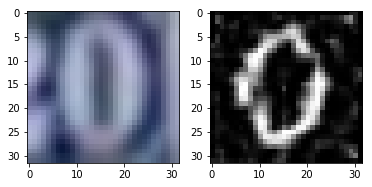

In [57]:
npimg = out_img.detach().numpy()
#print(npimg.shape)
npimg = np.transpose(npimg, (1, 2, 0))
#print(npimg.shape)
zero_array = np.zeros(npimg.shape)
one_array = np.ones(npimg.shape)
npimg = np.minimum(npimg,one_array)
npimg = np.maximum(npimg,zero_array)

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(npimg)
plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


KeyboardInterrupt: 

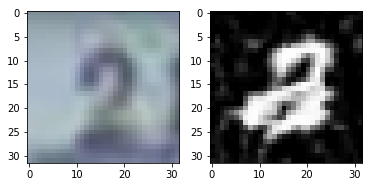

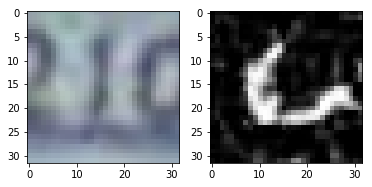

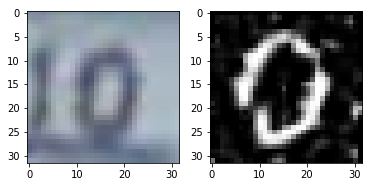

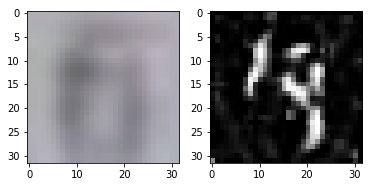

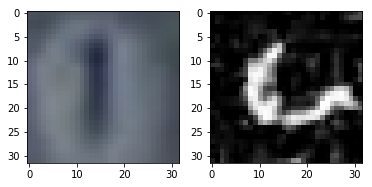

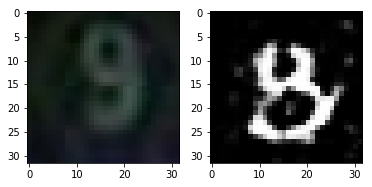

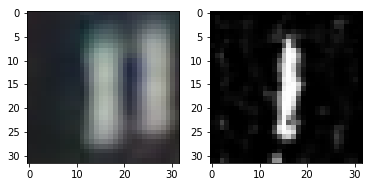

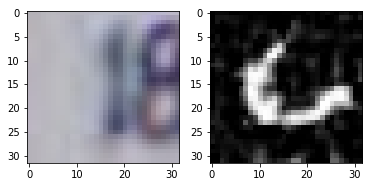

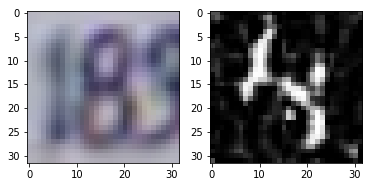

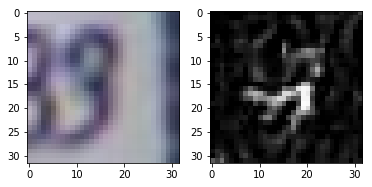

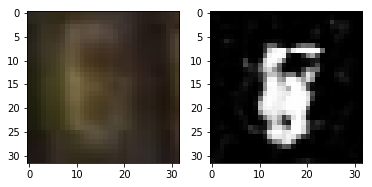

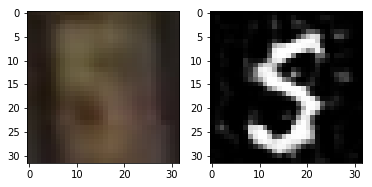

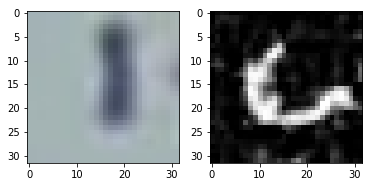

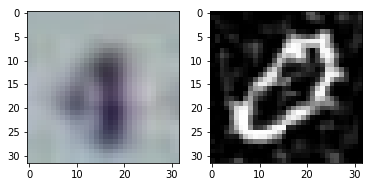

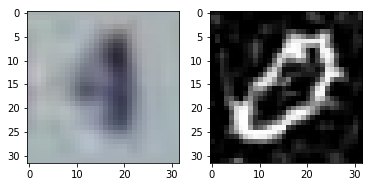

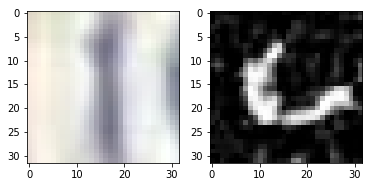

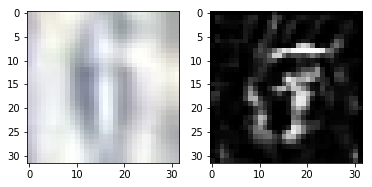

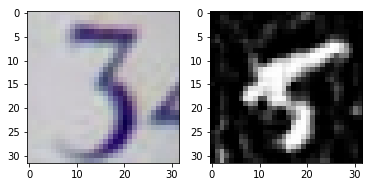

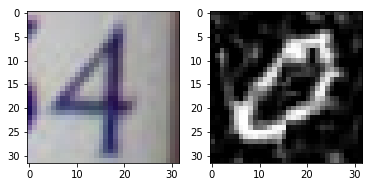

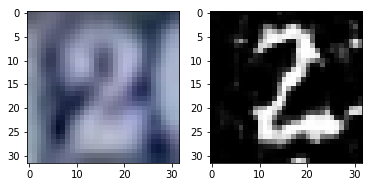

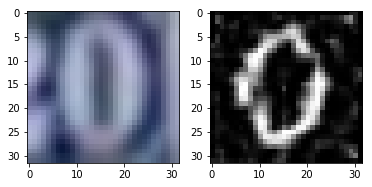

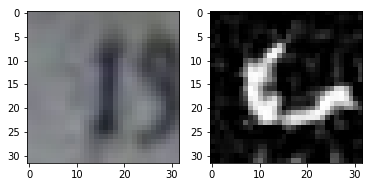

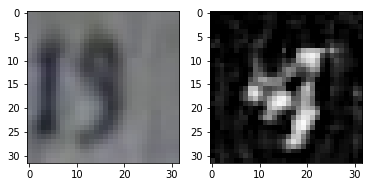

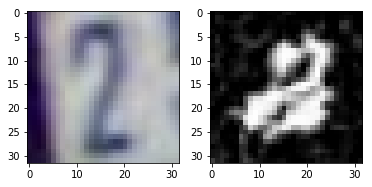

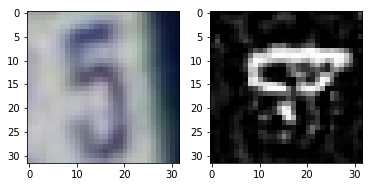

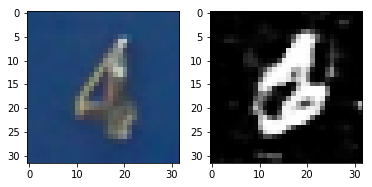

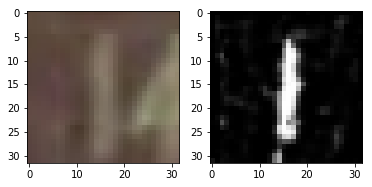

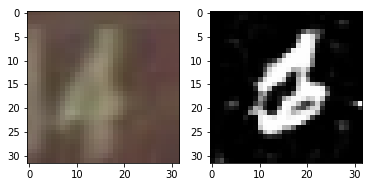

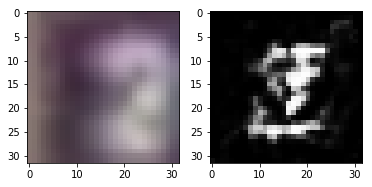

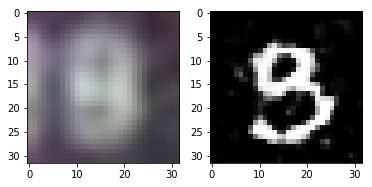

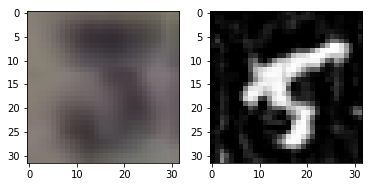

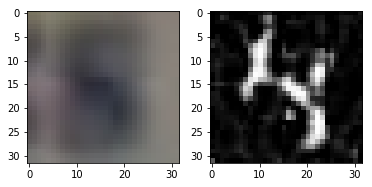

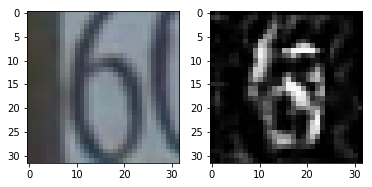

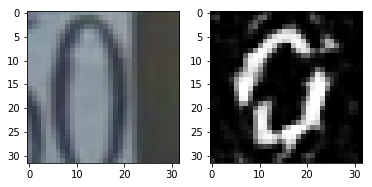

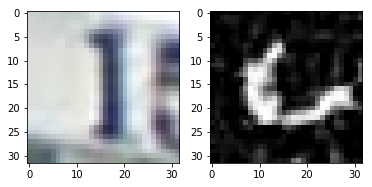

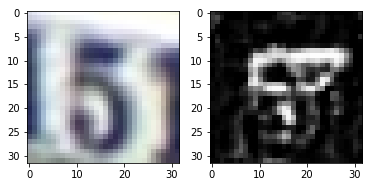

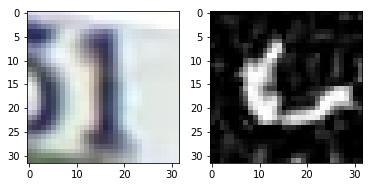

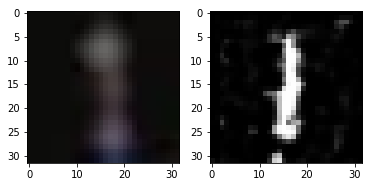

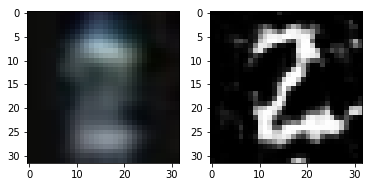

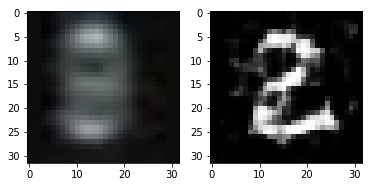

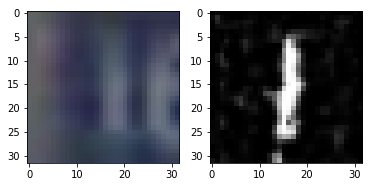

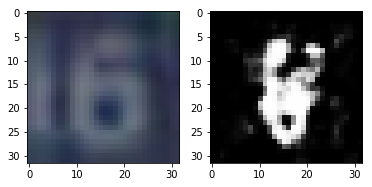

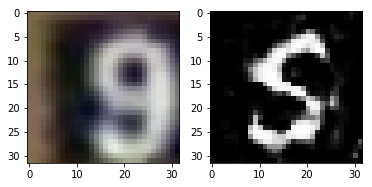

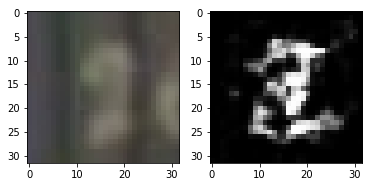

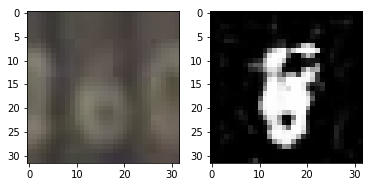

<Figure size 432x288 with 0 Axes>

In [59]:
for i in xrange(1,1000):
    img = get_svhn_image(i)
    load_transforms = transforms.Compose([transforms.ToTensor(), NormalizeRangeTanh()])
    image = load_transforms(img)
    image = image.unsqueeze(0)

    img_data = Variable(image.cpu().float())

    s_f = f_model(img_data)
    s_g = model['G'].cpu()(s_f)

    unnormRange = UnNormalizeRangeTanh()
    out_img = torchvision.utils.make_grid(unnormRange(s_g[:16]), nrow=4)
    npimg = out_img.detach().numpy()
    #print(npimg.shape)
    npimg = np.transpose(npimg, (1, 2, 0))
    #print(npimg.shape)
    zero_array = np.zeros(npimg.shape)
    one_array = np.ones(npimg.shape)
    npimg = np.minimum(npimg,one_array)
    npimg = np.maximum(npimg,zero_array)
    #print(i)
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(img)
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(npimg)
    plt.savefig('./results/digits/outputs/'+str(i)+'.png')
    
    #fig = plt.figure()
    #ax1 = fig.add_subplot(1,1,1)
    #ax1.imshow(npimg)
    #plt.savefig('./results/digits/evals/'+str(i)+'.png')